# Математические пакеты. Лабораторная работа 1
Субботин Максим гр. 9382 Вариант 18

# Цель работы
Изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

# Задачи
#### 1. Освоить Jupyter Notebook.
#### 2. [Выполнить загрузку аудио сигнала и построить огибающую (график).](#id1)
#### 3. [Фильтрация, получить фильтрованный сигнал.](#id2)
#### 4. [Детектор сигнал/шум. Получить сигнал после детектирования](#id3)
#### 5. [Эффект "Эхо". Получить сигнал после работы аудио-эффекта.](#id4)
#### 6. [Эффект "Distortion". Получить сигнал после работы аудио-эффекта.](#id5)

## <a name ="id1">Выполнение загрузки аудио сигнала и построение огибающей </a>

Имеется сигнал $x(i), i = 0, 1, ... , N-1$ Необходимо построить огибающую $y(j), j = 0, 1, ... , n - 1$

Пусть $m = \left[ {N \over n} \right]$ - число точек в интервале усреднения. Тогда: $y(j) = {1 \over m}\sum \limits_{k=mj}^{mj+m-1}|x(k)|$


200200


<ipython-input-107-9534155cc5f0>:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  freq_sample, sig_audio = wavfile.read('03-01-05-01-01-02-18_A18.wav')
<ipython-input-107-9534155cc5f0>:6: WavFileWarning: Incomplete chunk ID: b'\x00', ignoring it.
  freq_sample, sig_audio = wavfile.read('03-01-05-01-01-02-18_A18.wav')


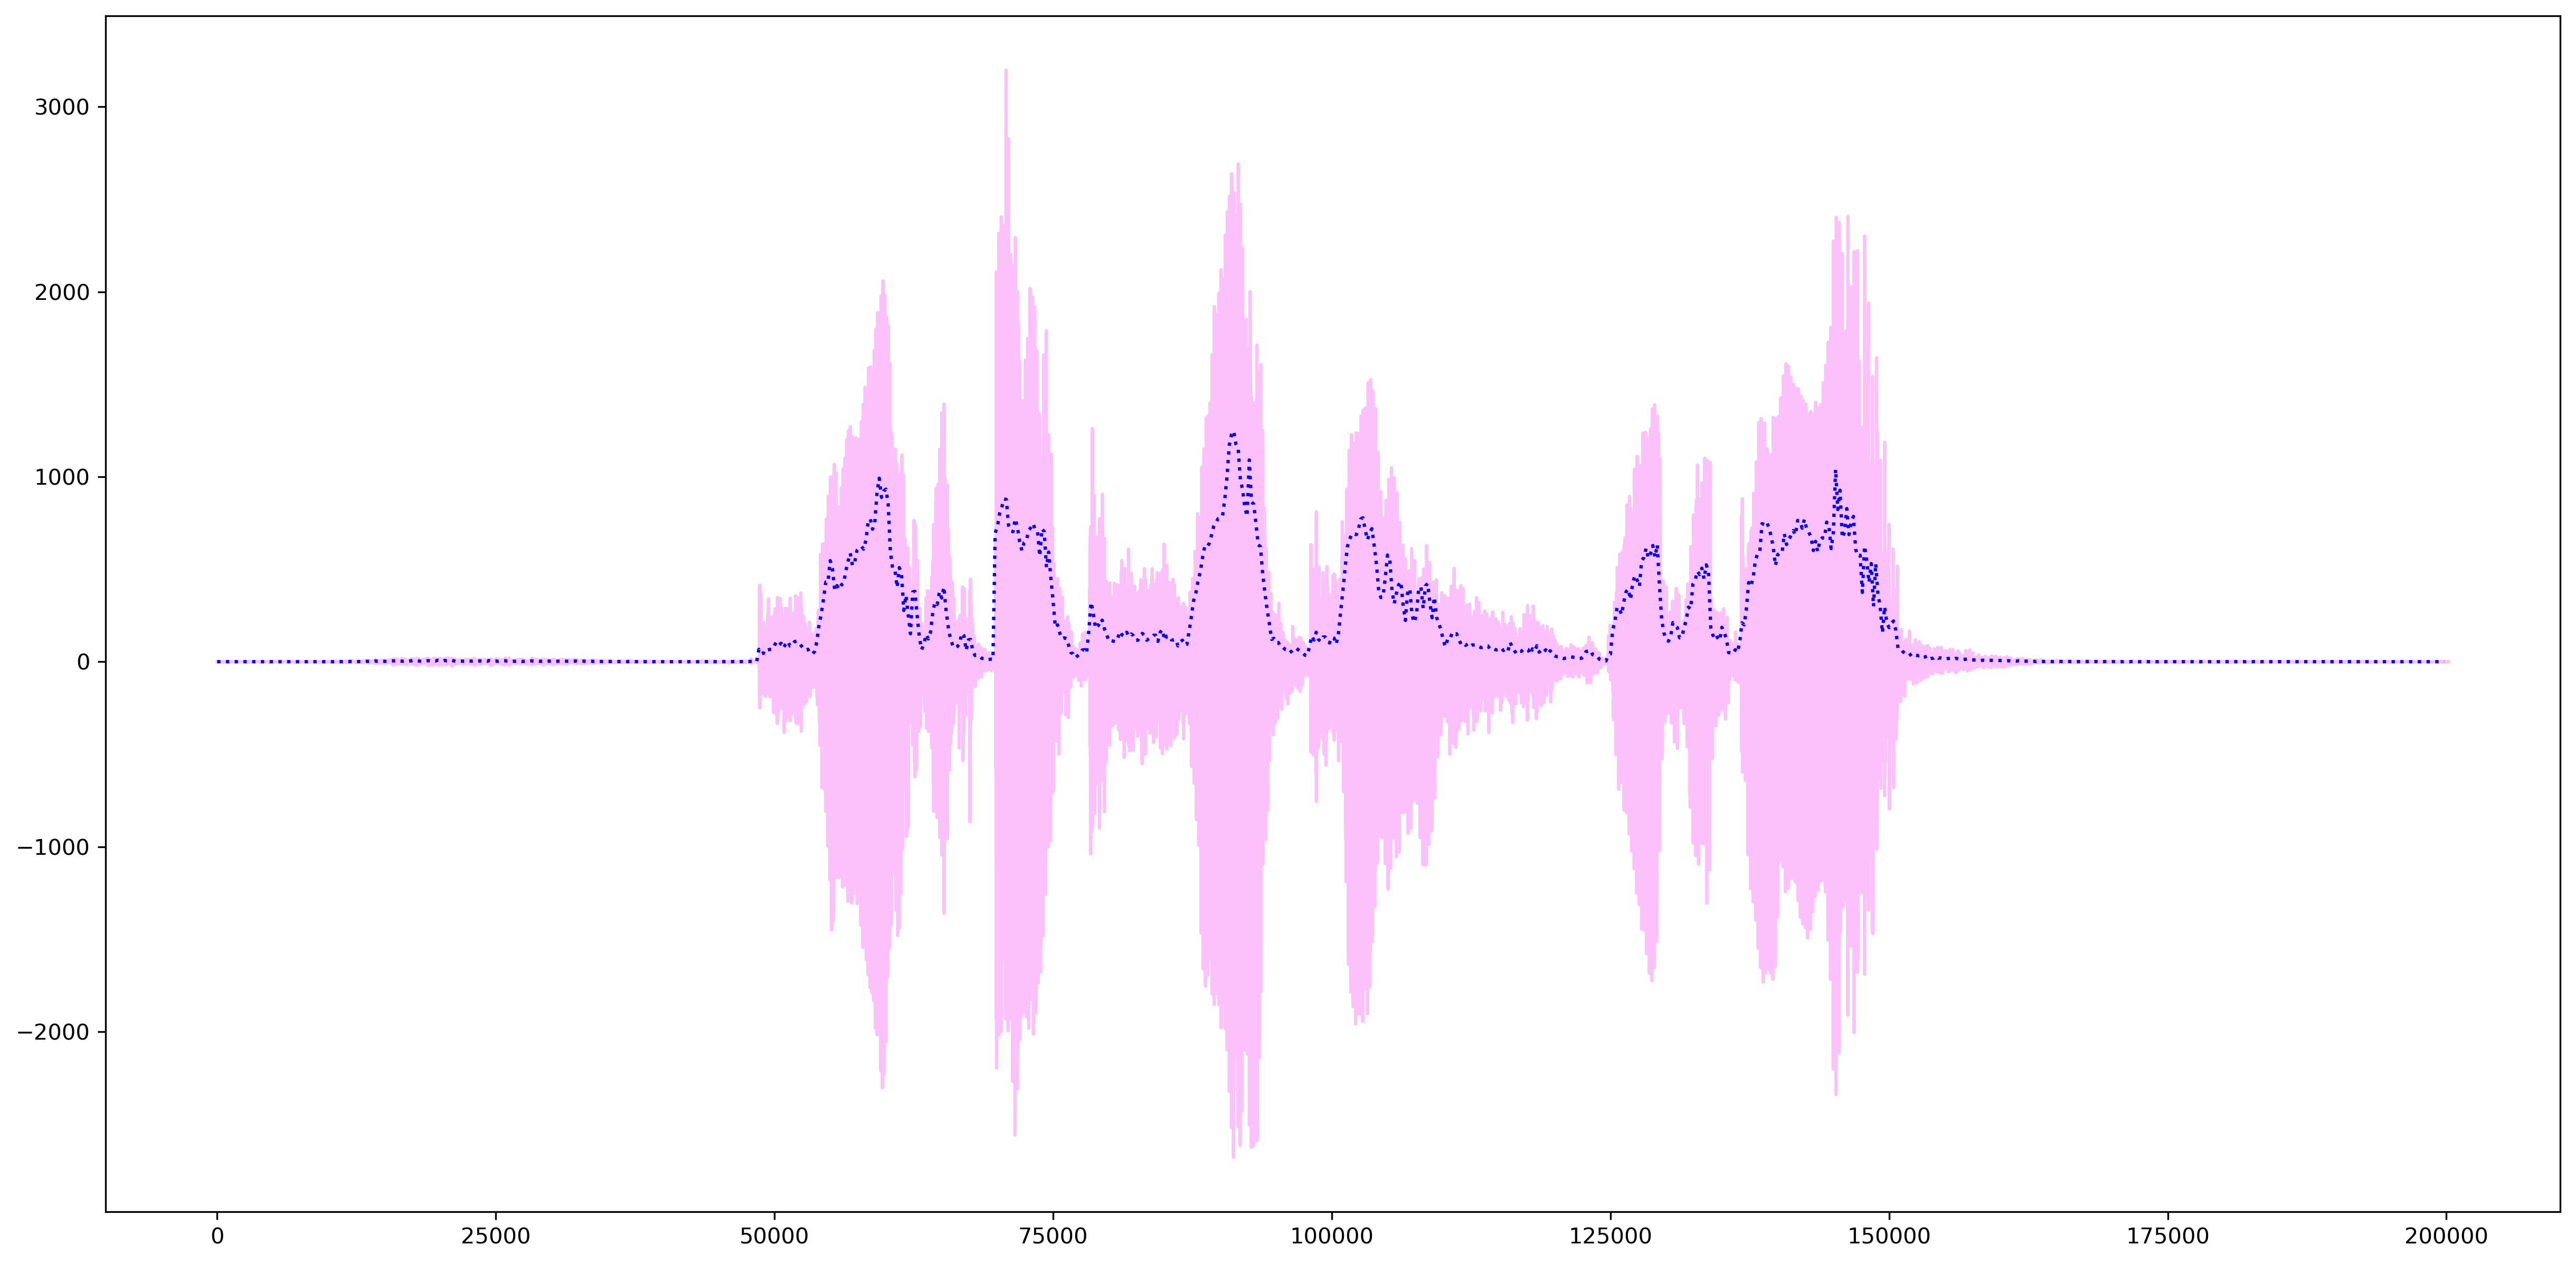

In [107]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["figure.dpi"] = 300
freq_sample, sig_audio = wavfile.read('03-01-05-01-01-02-18_A18.wav')

n = 1000
m = round(len(sig_audio)/n)
y = []
x = []
for j in range(0,n):
    sum = 0
    for k in range(m*j,m*j+m):
        sum+=abs(sig_audio[k])
    sum = sum / m
    y.append(sum)
    x.append(j*m)

    
print(len(sig_audio))

x_sig = []
for i in range(0,len(sig_audio)):
    x_sig.append(i)

plt.plot(x_sig, sig_audio, color='#FCC1FB')
plt.plot(x, y, color="blue", linestyle="dotted")

## <a name="id2"> Фильтрация, получение фильтрованного сигнала </a>

Был выбран фильтр нижних частот.

Пусть $F_d$ - частота дискретизации, частота среза - $F_s$, порядок фильтра равен $m$.

Тогда $wn = 2 {F_s \over F_d}$

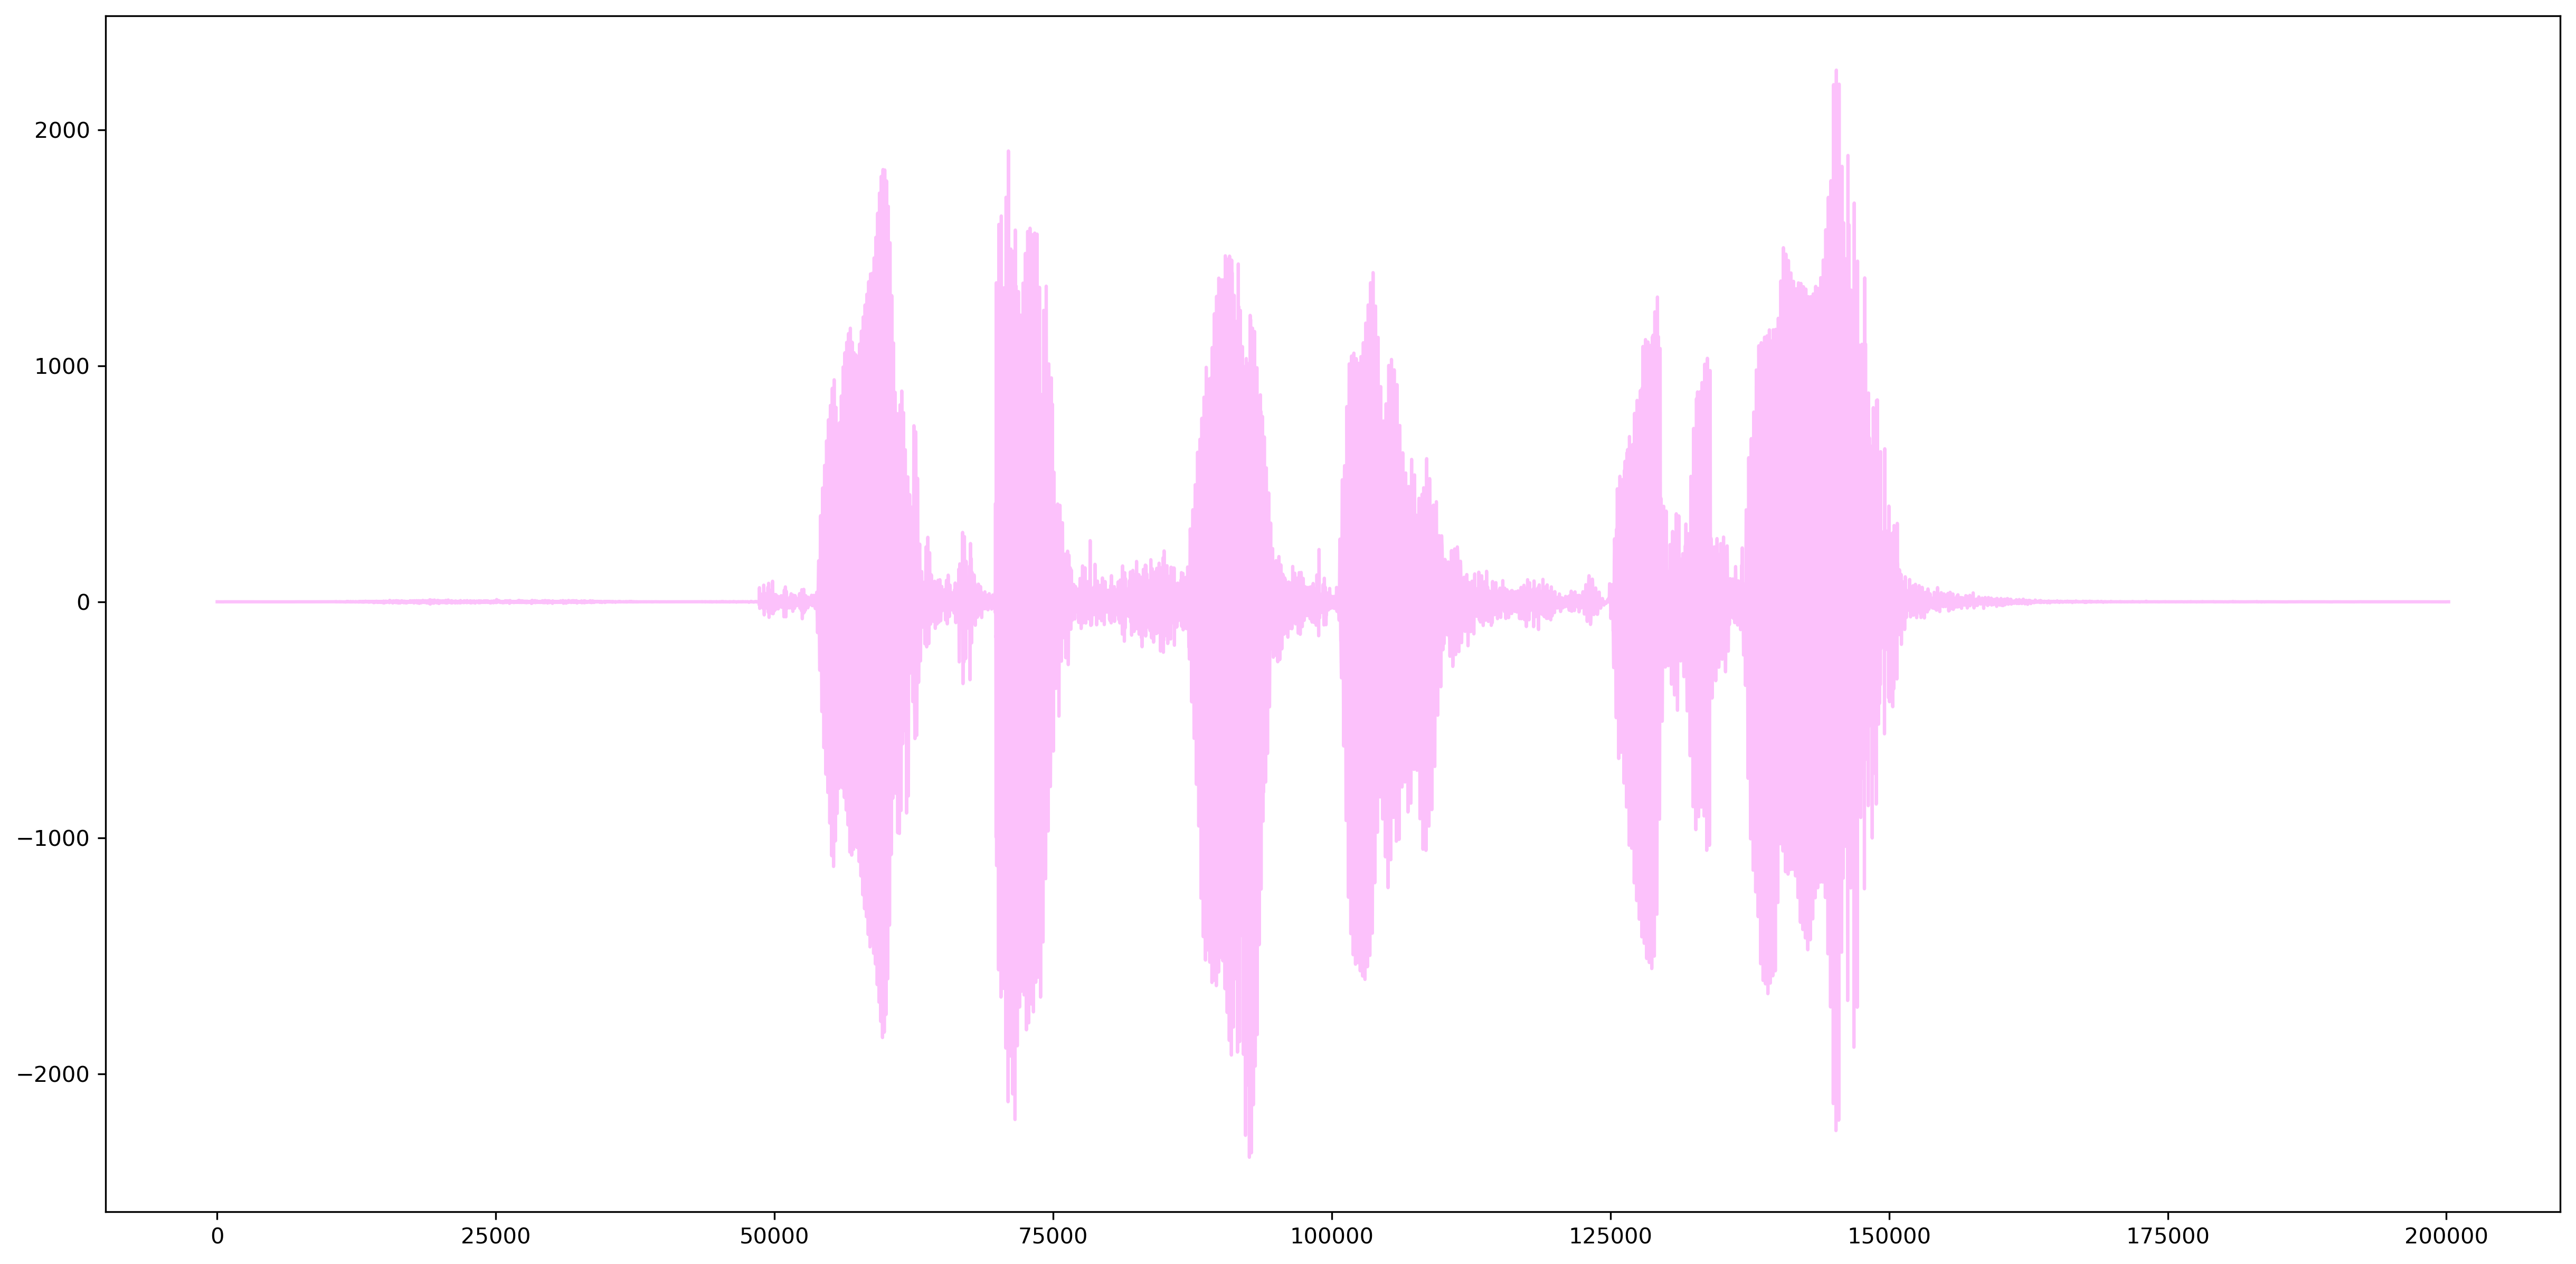

In [109]:
from scipy import signal
wn = 2*1200/freq_sample
b,a = signal.butter(5,wn,'lowpass')
filtedData = signal.filtfilt(b,a,sig_audio)
plt.plot(x_sig, filtedData, color='#FCC1FB')
wavfile.write("example.wav",freq_sample, filtedData.astype(np.int16))
import IPython
IPython.display.Audio(filtedData, rate=freq_sample)

В сравнении с предыдущим графиком видно, что амплитуда теперь не превышает 2000.

## <a name="id3"> Амплитудный детектор сигнал/шум </a>

Среднее сигнала по амплитуде: $mid ={1 \over N} \sum\limits_{k=0}^{N-1} |x(k)|$

Порог детектора $Th = \alpha * mid$, где $0 < \alpha < 1$ подбирается экспериментальным путем.

Задается величина провала $k$ (в отсчетах). $y(j)$ - сигнал после детектирования.

Сигнал начинается, если $x(i)$ в течении $k$ отсчетов превышает порог, тогда $y(i) = x(i)$.

Сигнал заканчивается, если $x(i)$ в течении $k$ отсчетов меньше порога, тогда $y(i) = 0$.





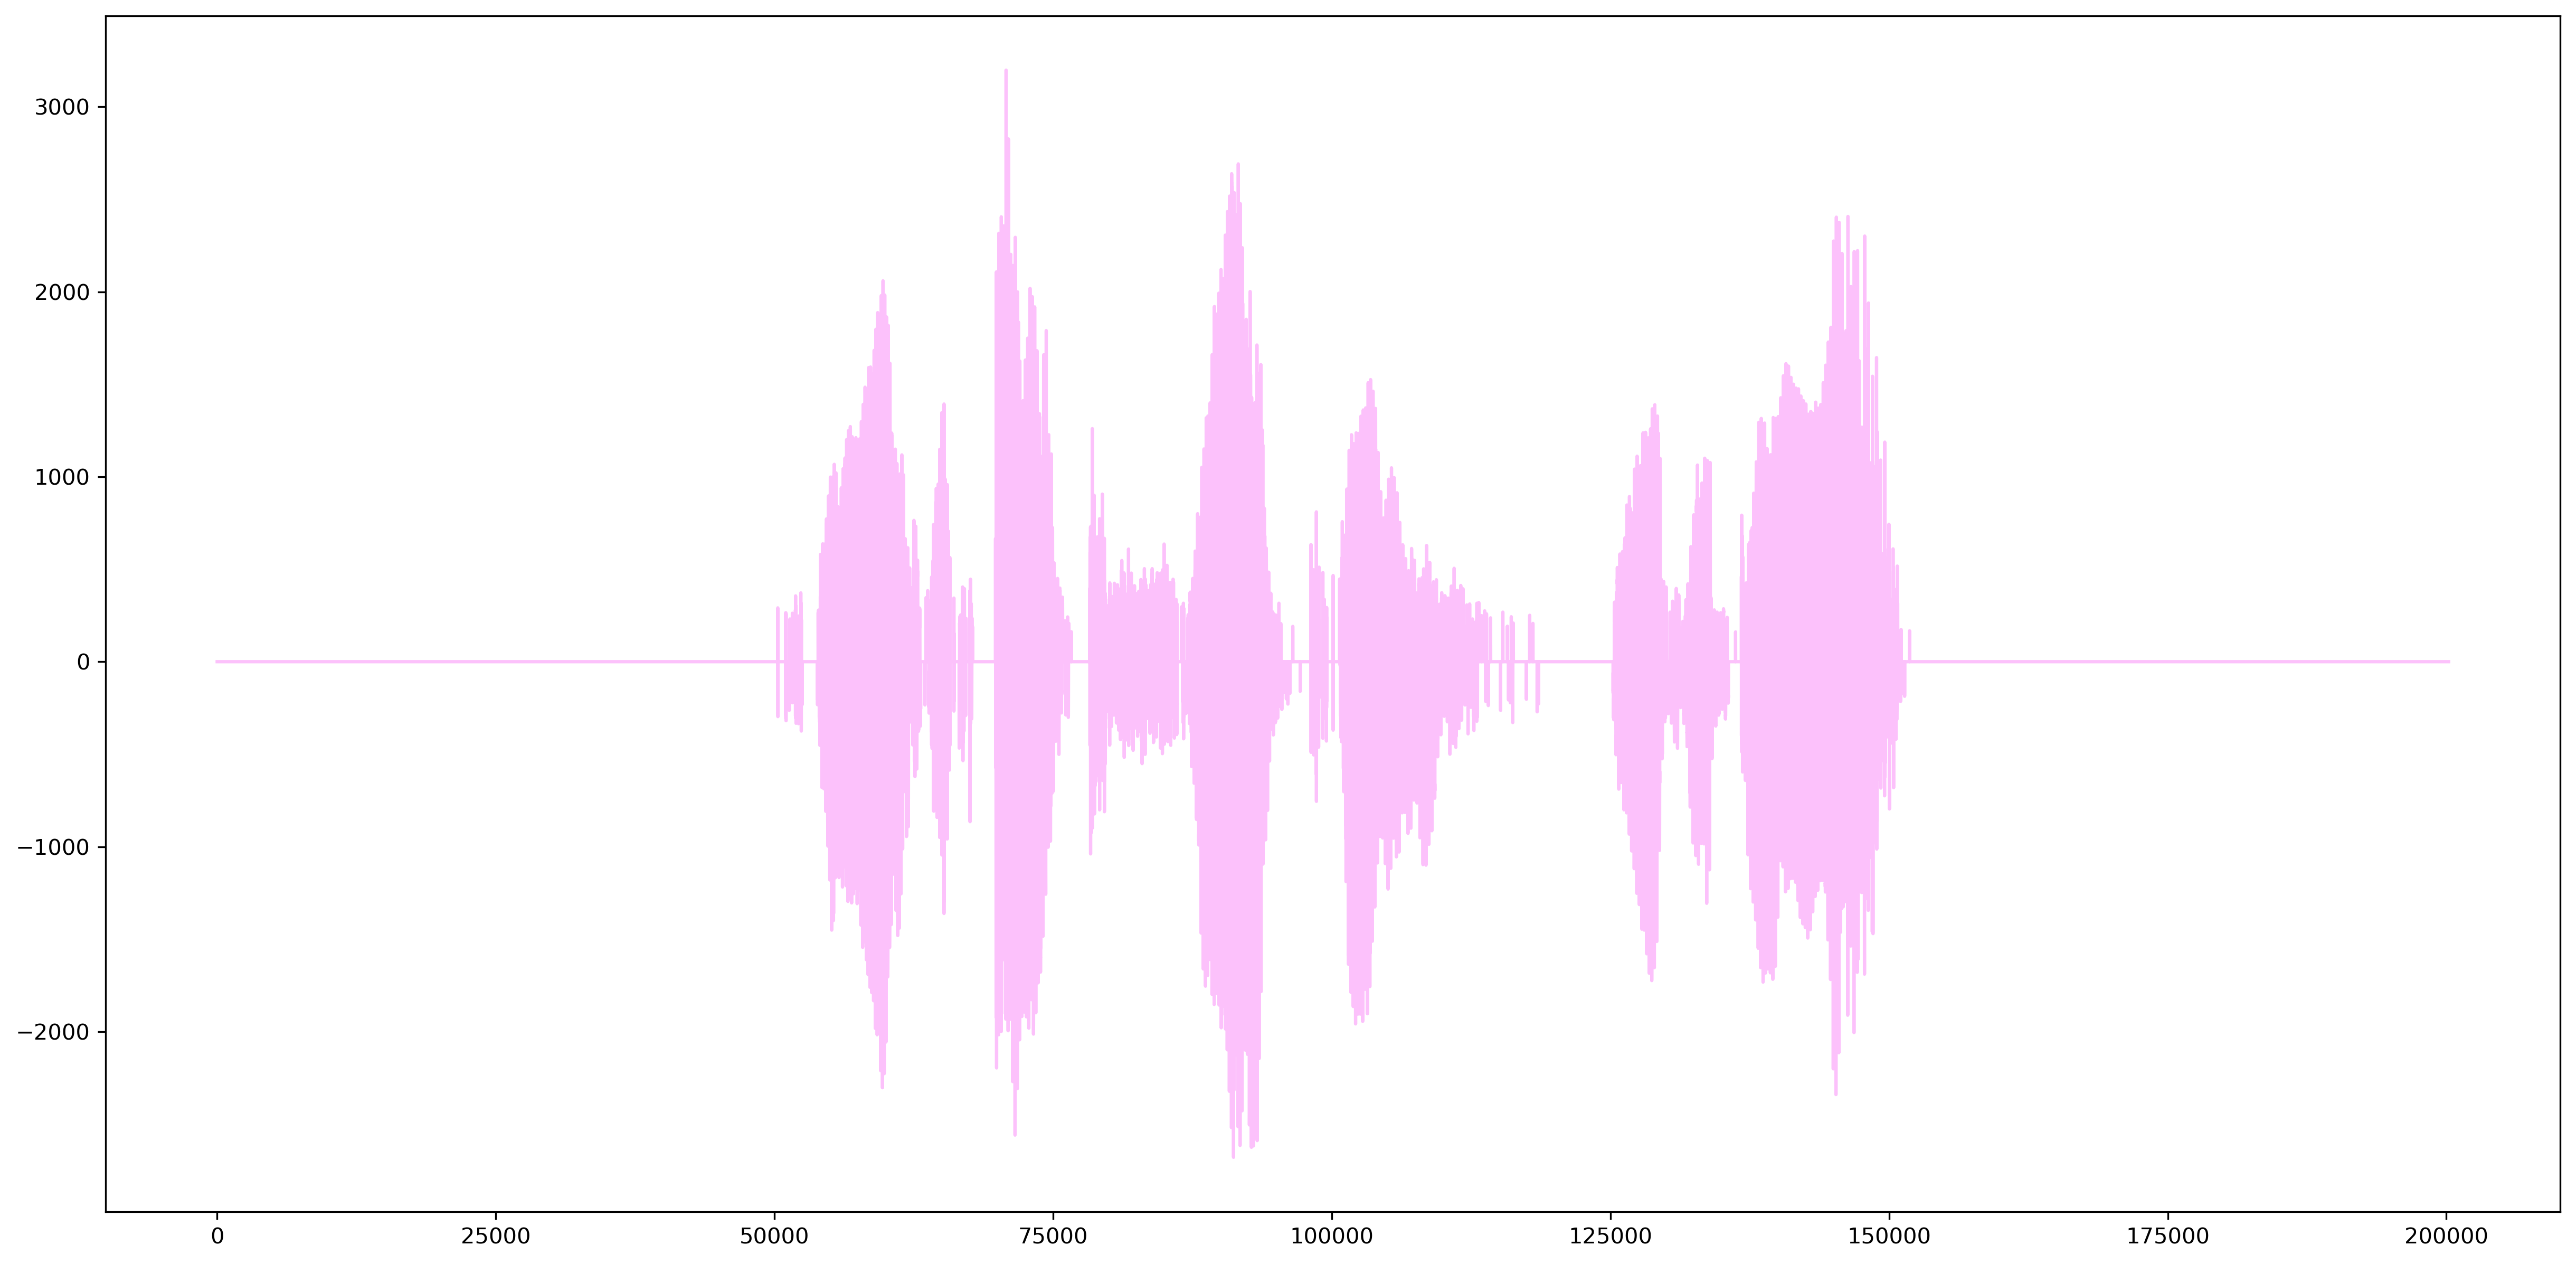

In [110]:
mid = 0

def checkNext(j, gap, data, mid, needStart):
    for i in range(j,j+gap):
        if needStart:
            if abs(data[i]) < mid:
                return False
        else:
            if abs(data[i]) >= mid:
                return False
    return True

for k in range(0,len(sig_audio)):
    mid += abs(sig_audio[k])
mid /= len(sig_audio)
alpha = 0.9
mid *= alpha
down = 5
new_signal = []
j = 0
start = False
while j < len(sig_audio):
    if abs(sig_audio[j]) >= mid:
        if not start:
            if checkNext(j,down,sig_audio,mid, not start):
                new_signal.append(sig_audio[j])
                start = True
            else:
                new_signal.append(0)
        else:
            new_signal.append(sig_audio[j])
    else:
        if start:
            if checkNext(j,down,sig_audio,mid, not start):
                new_signal.append(0)
                start = False
            else:
                new_signal.append(sig_audio[j])
        else:
            new_signal.append(0)
    j+=1

plt.plot(x_sig, new_signal, color='#FCC1FB')                
            
wavfile.write("example2.wav",freq_sample, np.array(new_signal).astype(np.int16))

import IPython
IPython.display.Audio(np.array(new_signal).astype(np.int16), rate=freq_sample)
        

В аудио исчез звук дыхания оратора, но при этом добавилась нечеткость в аудио сигнале (как звук при поиске подходящей радиостанции в машине).

## <a name="id4"> Эхо (простейший ревербератор) </a>

Ревербератор состоит из 8 линий задержки. Каждая линия задержки имеет свой весовой коэффициент. Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка. Соотношение между начальным и обработанным сигналом задается коэффициентом применимости $\gamma$.

Значения задержек: $D_i = D_1 * 2^{(1-i)/N_L}, i = 2,...,N_L$

Весовые коэффициенты при линиях задержек: $\alpha_i = {\alpha_1 / {2^{i}}}$



In [108]:
d = [20000]
for i in range(2,9):
    d.append(round(d[0] * 2**((1-i)/8)))
delayed_signals = []
start_signal = sig_audio
tilda = [0.9/(2**(i)) for i in range(0,8)]

def mult(sig, j):
    for i in range(0,len(sig)):
        sig[i]*=tilda[j]
    return sig
    

j = 0
for di in d:
    sig = [0]*di
    sig.extend(start_signal)
    delayed_signals.append(mult(sig,j))
    j+=1

delayed_signal = delayed_signals[0]
for i in range(1,8):
    for j in range(0, len(delayed_signals[i])):
        delayed_signal[j] += delayed_signals[i][j]

filtedDelayed = signal.filtfilt(b,a,delayed_signal)    

for i in range(0,len(filtedDelayed)):
    filtedDelayed[i]*=0.8
for i in range(0,len(start_signal)):
    filtedDelayed[i]+=start_signal[i]
    
wavfile.write("example3.wav",freq_sample, np.array(filtedDelayed).astype(np.int16)) 
import IPython
IPython.display.Audio(np.array(filtedDelayed).astype(np.int16), rate=freq_sample)

На аудиозаписи действительно слышно эхо.

## <a name="id5">Классический Distortion

$x(i)$ - входной сигнал, $y(i)$ - выходной сигнал, где $i = 0, 1, ..., N-1$. 

$Th$ - порог, $max$ - максимальное значения сигнала, где $max > Th$

Тогда $Y(i) = \begin{cases} x(i), |x(i)| \leqslant Th \\ max*sign(x(i)), |x(i)| > Th \end{cases}$

<ipython-input-106-1c7dbcb6dd9f>:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sign = lambda x: (1, -1)[x<0]


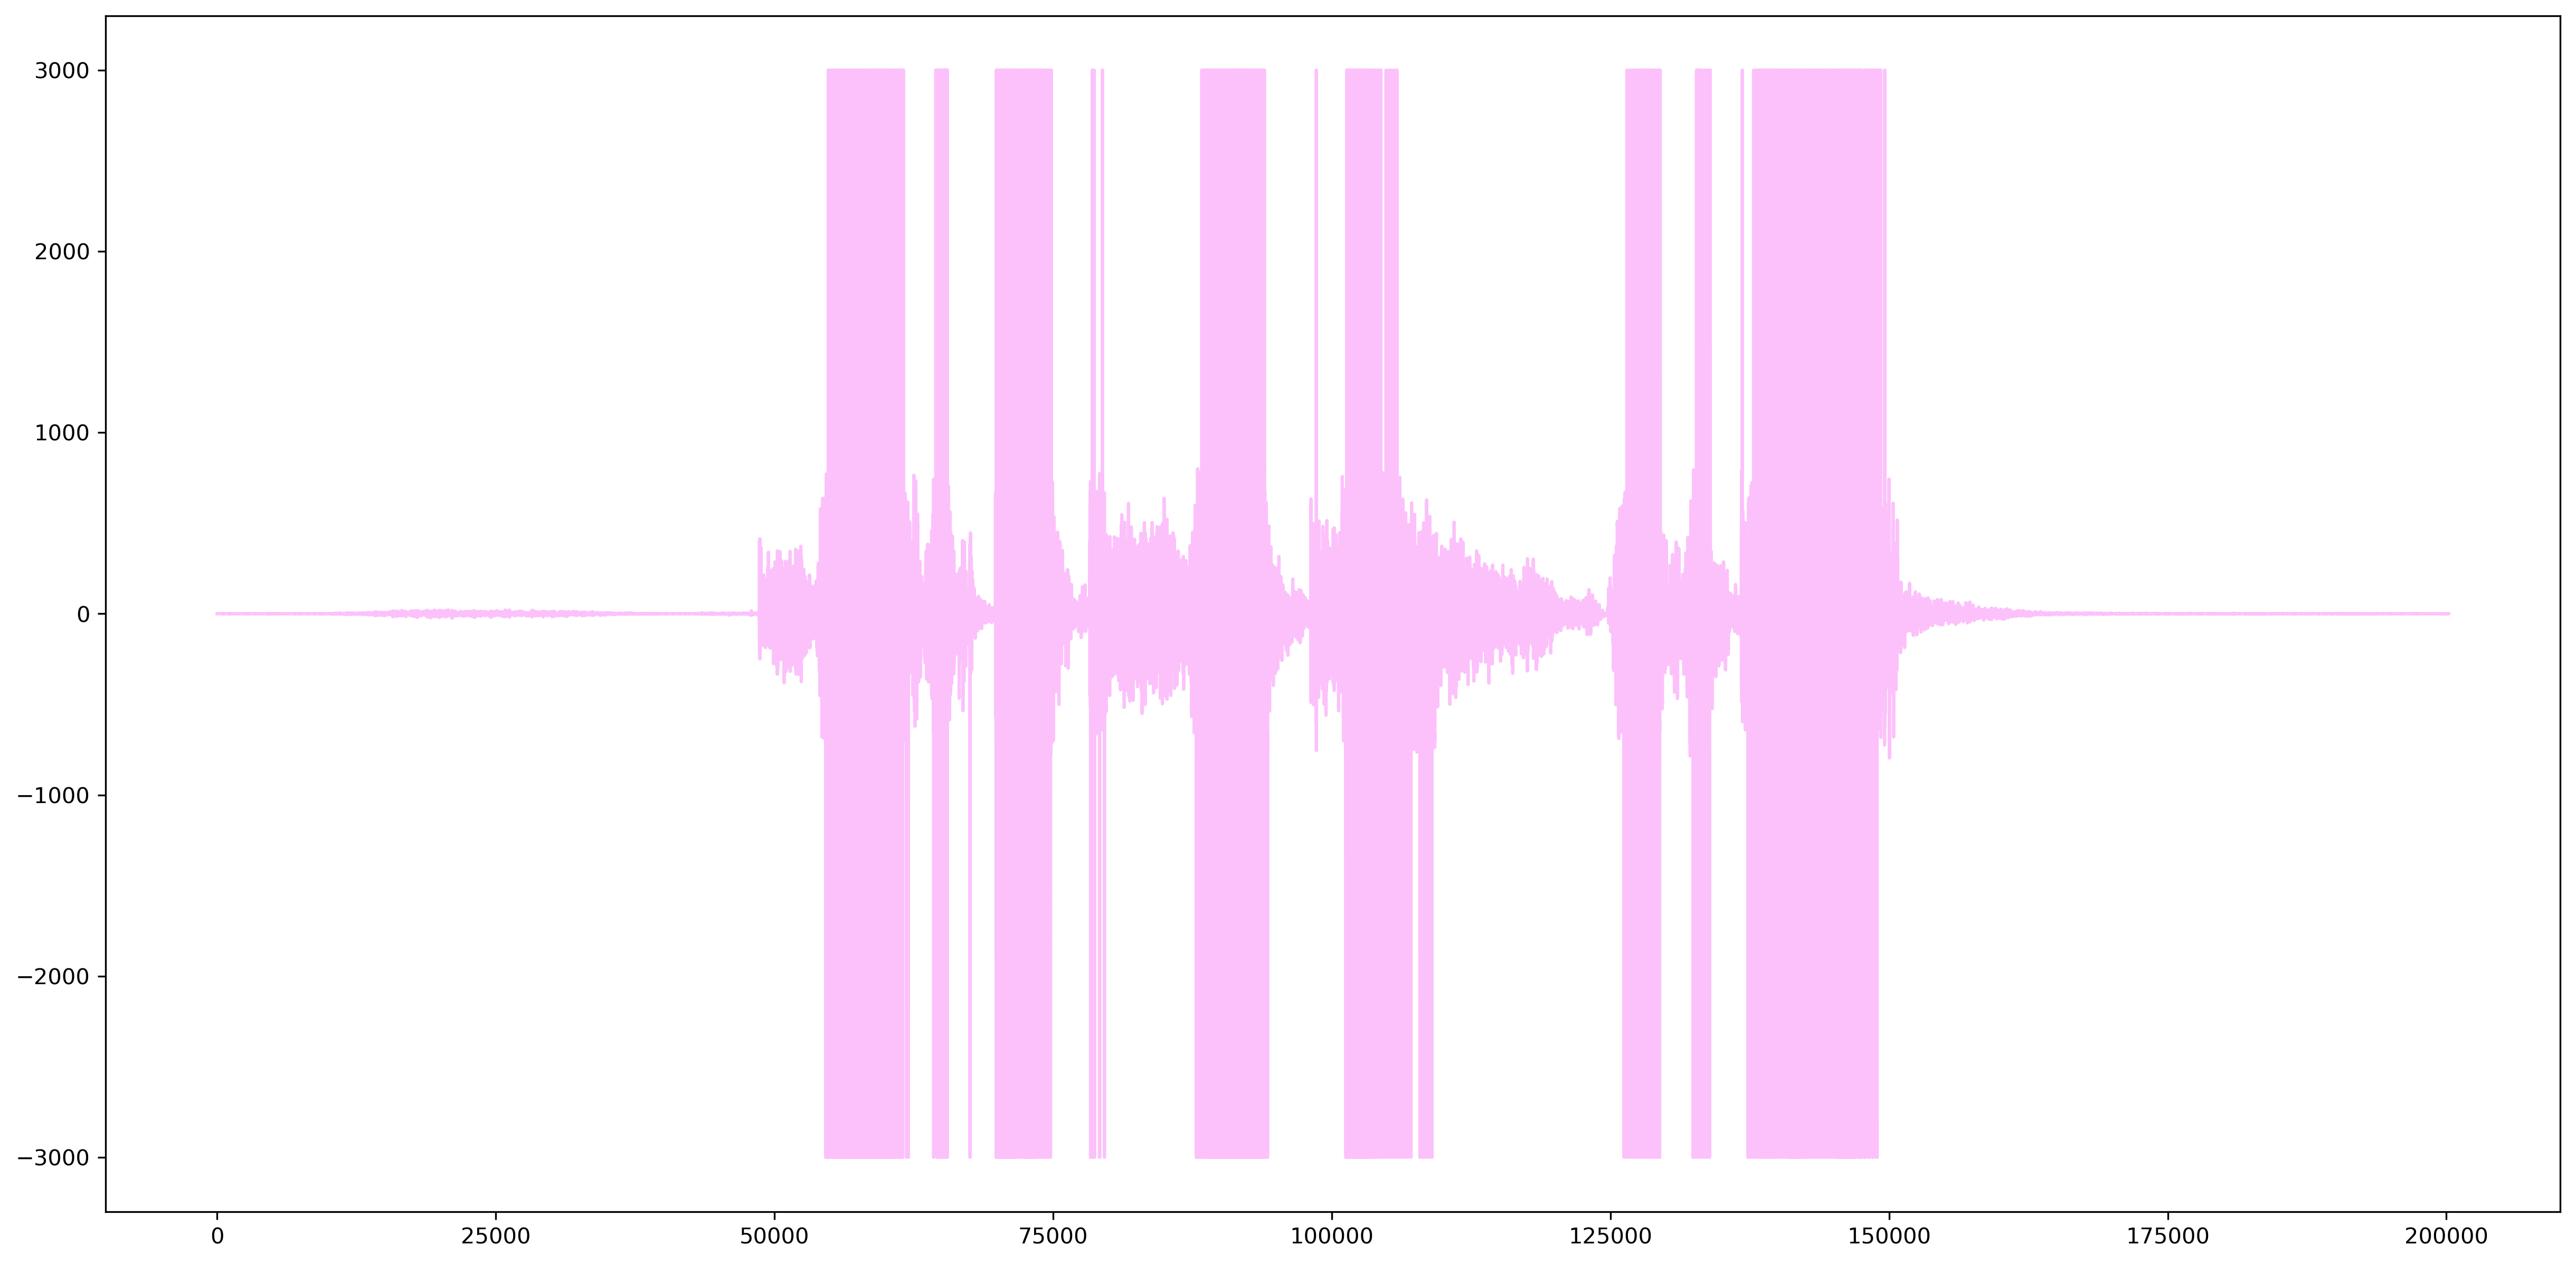

In [106]:
Th = 800
maxTh = 3000
distortion_signal = []
sign = lambda x: (1, -1)[x<0]
for i in range(0,len(sig_audio)):
    if abs(sig_audio[i]) <= Th:
        distortion_signal.append(sig_audio[i])
    else:
        distortion_signal.append(maxTh*sign(sig_audio[i]))
plt.plot(x_sig, distortion_signal, color='#FCC1FB') 
wavfile.write("example4.wav",freq_sample, np.array(distortion_signal).astype(np.int16))
import IPython
IPython.display.Audio(np.array(distortion_signal).astype(np.int16), rate=freq_sample)

На графике видно как местами амплитуда достигает максимального значения на некотором(относительно длительном) промежутке.

## Вывод
Были изучены возможности Python для работы с цифровыми сигналами. Была выполнена загрузка цифрового сигнала с проведением над ним следующих действий: построение графика огибающей, фильтрация сигнала, построение детектора сигнал/шум, реализация и наложение эффектов "Эхо" и "Distortion".